In [2]:
from fktools import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeMarrakesh
from qiskit.visualization import plot_histogram

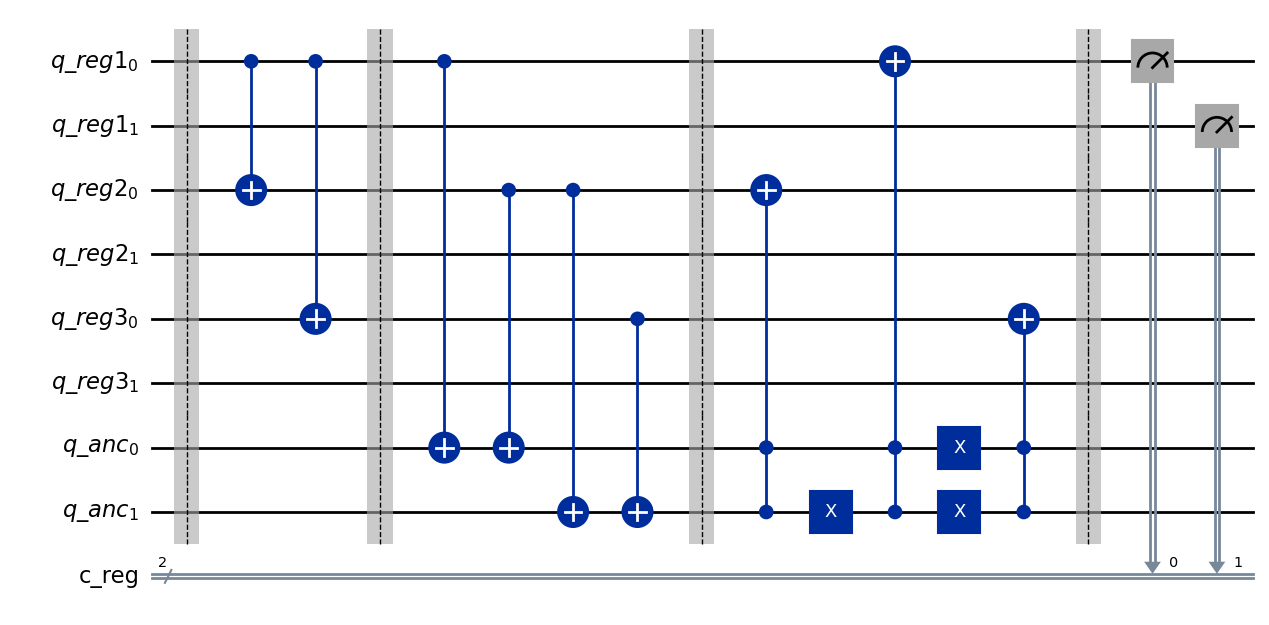

In [14]:
q_reg1 = QuantumRegister(2, "q_reg1")
q_reg2 = QuantumRegister(2, "q_reg2")
q_reg3 = QuantumRegister(2, "q_reg3")
q_anc = QuantumRegister(2, "q_anc")
c_reg = ClassicalRegister(2, "c_reg")

qc =QuantumCircuit(q_reg1, q_reg2, q_reg3, q_anc, c_reg)



qc.barrier()

qc.cx(q_reg1[0], q_reg2[0])
qc.cx(q_reg1[0], q_reg3[0])

qc.barrier()

qc.cx(q_reg1[0], q_anc[0])
qc.cx(q_reg2[0], q_anc[0])
qc.cx(q_reg2[0], q_anc[1])
qc.cx(q_reg3[0], q_anc[1])

qc.barrier()

qc.ccx(q_anc[0], q_anc[1], q_reg2[0])

qc.x(q_anc[1])
qc.ccx(q_anc[0], q_anc[1], q_reg1[0])

qc.x(q_anc[0])
qc.x(q_anc[1])
qc.ccx(q_anc[0], q_anc[1], q_reg3[0])

qc.barrier()

qc.measure(q_reg1[0], c_reg[0])
qc.measure(q_reg1[1], c_reg[1])

qc.draw('mpl')

transpiled


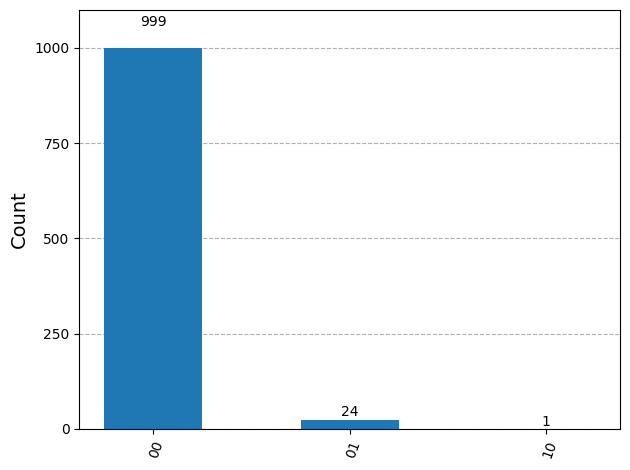

In [15]:
simulator = FakeMarrakesh()

tcirc = transpile(qc, simulator, optimization_level=3)
print("transpiled")
result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

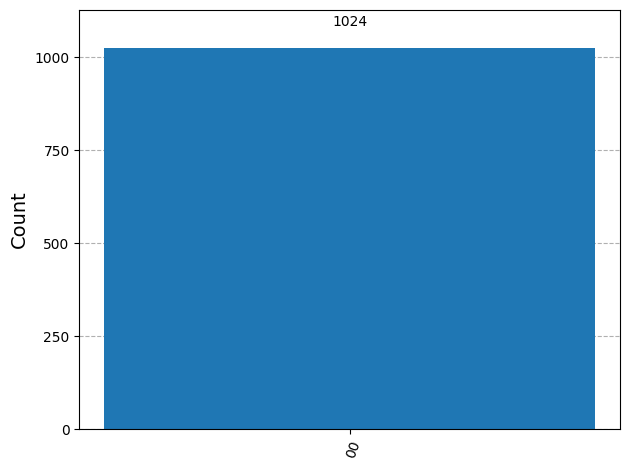

In [16]:
simulator = AerSimulator()

tcirc = transpile(qc, simulator)

result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

# c_if

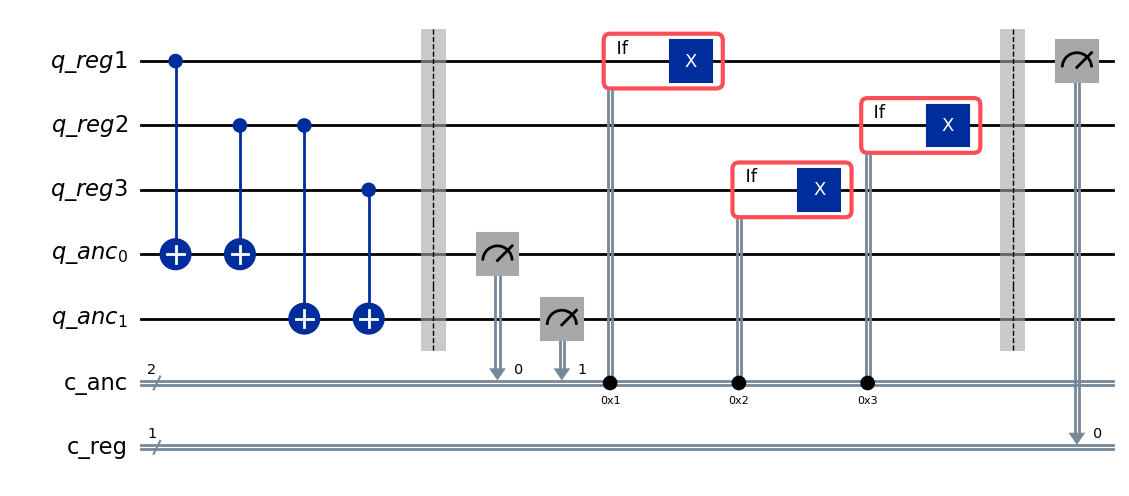

In [144]:
q_reg1 = QuantumRegister(1, "q_reg1")
q_reg2 = QuantumRegister(1, "q_reg2")
q_reg3 = QuantumRegister(1, "q_reg3")
q_anc = QuantumRegister(2, "q_anc")
c_anc = ClassicalRegister(2, "c_anc")
c_reg = ClassicalRegister(1, "c_reg")

qc =QuantumCircuit(q_reg1, q_reg2, q_reg3, q_anc, c_anc, c_reg)

qc.cx(q_reg1[0], q_anc[0])
qc.cx(q_reg2[0], q_anc[0])
qc.cx(q_reg2[0], q_anc[1])
qc.cx(q_reg3[0], q_anc[1])

qc.barrier()

qc.measure(q_anc, c_anc)

with qc.if_test((c_anc, 1)):
    qc.x(q_reg1[0])

with qc.if_test((c_anc, 2)):
    qc.x(q_reg3[0])

with qc.if_test((c_anc, 3)):
    qc.x(q_reg2[0])

# qc.x(q_reg3[0]).c_if(c_anc, 2)
# qc.x(q_reg2[0]).c_if(c_anc, 3)
# qc.ccx(q_anc[0], q_anc[1], q_reg2[0])

# qc.x(q_anc[1])
# qc.ccx(q_anc[0], q_anc[1], q_reg1[0])

# qc.x(q_anc[0])
# qc.x(q_anc[1])
# qc.ccx(q_anc[0], q_anc[1], q_reg3[0])

qc.barrier()

qc.measure(q_reg1[0], c_reg[0])

qc.draw('mpl')

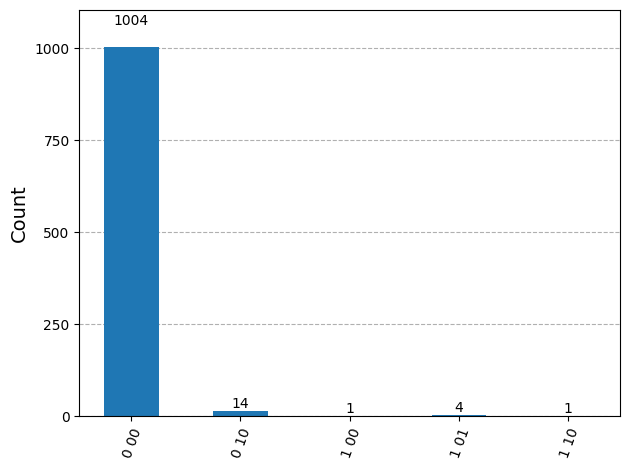

In [145]:
simulator = FakeMarrakesh()

tcirc = transpile(qc, simulator)

result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

# qw test

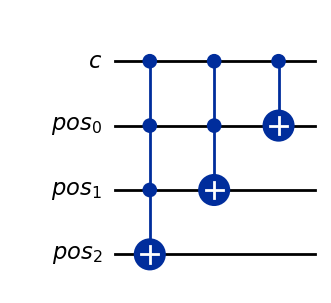

In [92]:
def control_add_one(position_qubits: int) -> QuantumCircuit:

    q_contol = QuantumRegister(1, "c")
    q_pos = QuantumRegister(position_qubits, "pos")

    regs = [q_contol, q_pos]

    qc = QuantumCircuit(*regs, name='control_add_one')

    for i in range(position_qubits, 0, -1):
        qc.mcx([j for j in range(i)], i)
    
    return qc

control_add_one(3).draw('mpl')

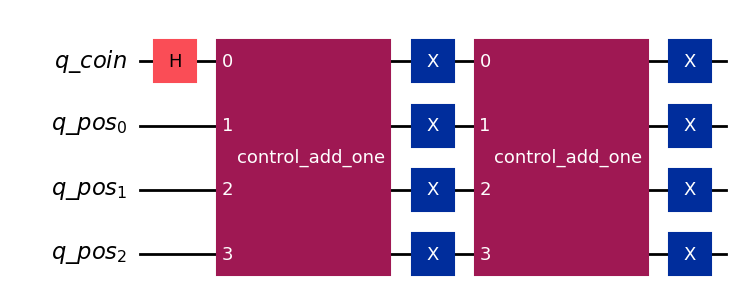

In [93]:
def walk_step(position_qubits: int) -> QuantumCircuit:
    q_pos = QuantumRegister(position_qubits, "q_pos")
    q_coin = QuantumRegister(1, "q_coin")
    regs = [q_coin, q_pos]

    qc = QuantumCircuit(*regs, name='walk_step')

    qc.h(q_coin)

    # shift right for coin |1>
    qc.append(control_add_one(position_qubits), [q_coin, *q_pos])
    
    # shift left for coin |0>
    qc.x(q_coin)
    qc.x(q_pos)
    qc.append(control_add_one(position_qubits), [q_coin, *q_pos])
    qc.x(q_coin)
    qc.x(q_pos)

    return qc
walk_step(3).draw('mpl')

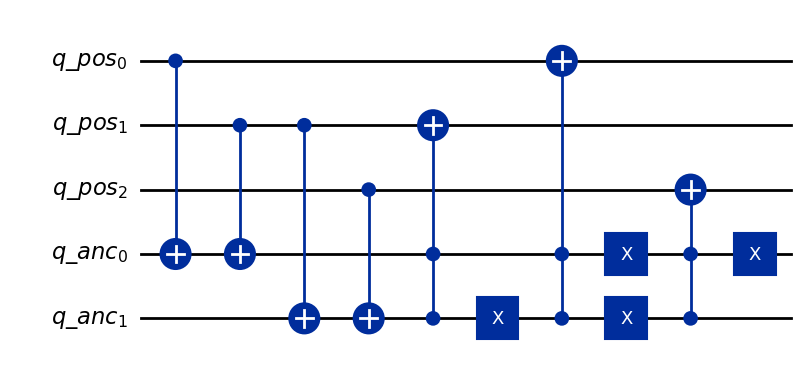

In [111]:
def simple_error_correction() -> QuantumCircuit:

    q_pos = QuantumRegister(3, "q_pos")
    q_anc = QuantumRegister(2, "q_anc")

    regs = [q_pos, q_anc]

    qc = QuantumCircuit(*regs, name="simple_ec")

    qc.cx(q_pos[0], q_anc[0])
    qc.cx(q_pos[1], q_anc[0])
    qc.cx(q_pos[1], q_anc[1])
    qc.cx(q_pos[2], q_anc[1])

    qc.ccx(q_anc[0], q_anc[1], q_pos[1])

    qc.x(q_anc[1])
    qc.ccx(q_anc[0], q_anc[1], q_pos[0])
    qc.x(q_anc[1])
    
    qc.x(q_anc[0])
    qc.ccx(q_anc[0], q_anc[1], q_pos[2])
    qc.x(q_anc[0])

    return qc
simple_error_correction().draw('mpl')

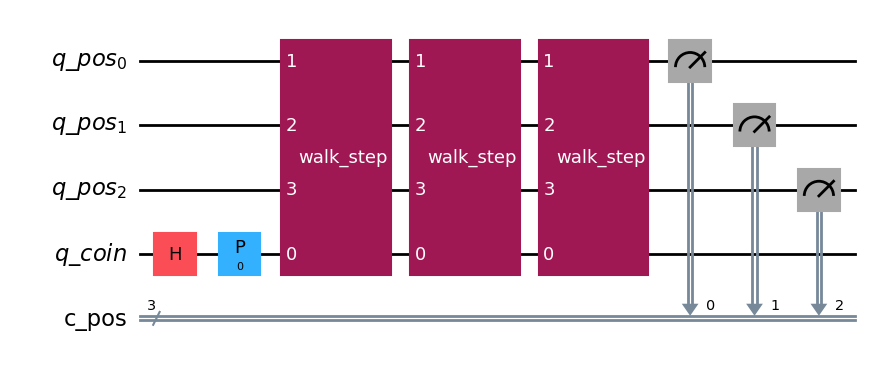

In [112]:
nodes_power = 3
num_steps = 3
coin_phase = 0

q_pos = QuantumRegister(nodes_power, "q_pos")
q_coin = QuantumRegister(1, "q_coin")
c_pos = ClassicalRegister(nodes_power, "c_pos")
regs = [q_pos, q_coin, c_pos]

qc = QuantumCircuit(*regs)

qc.h(q_coin)
qc.p(coin_phase, q_coin)

for step in range(num_steps):
    qc.append(walk_step(nodes_power), [q_coin, *q_pos])


qc.measure(q_pos, c_pos)

qc.draw('mpl')


transpiled


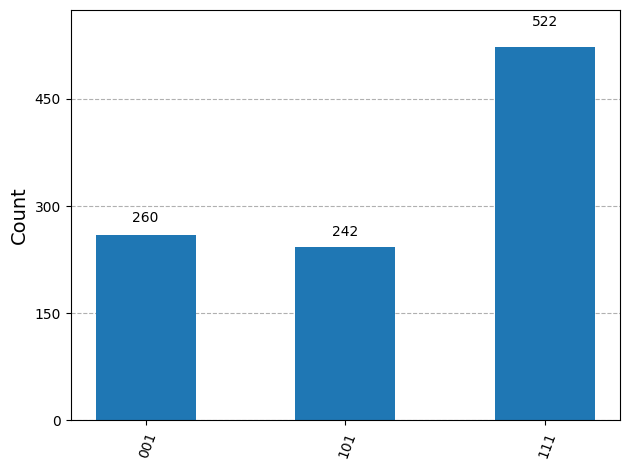

In [113]:
simulator = AerSimulator()

tcirc = transpile(qc, simulator)
print("transpiled")
result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

transpiled


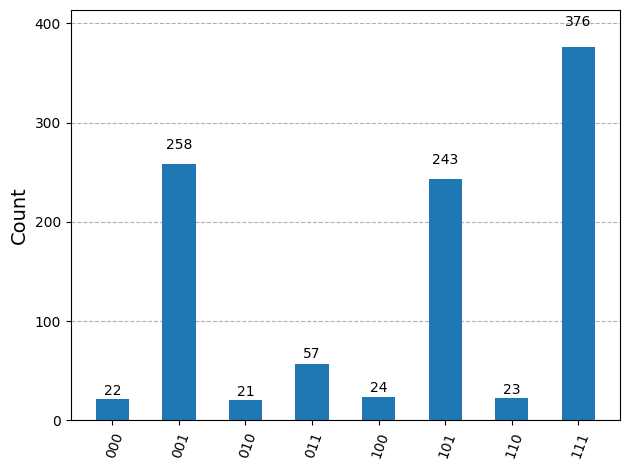

In [114]:
simulator = FakeMarrakesh()

tcirc = transpile(qc, simulator, optimization_level=3)
print("transpiled")
result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

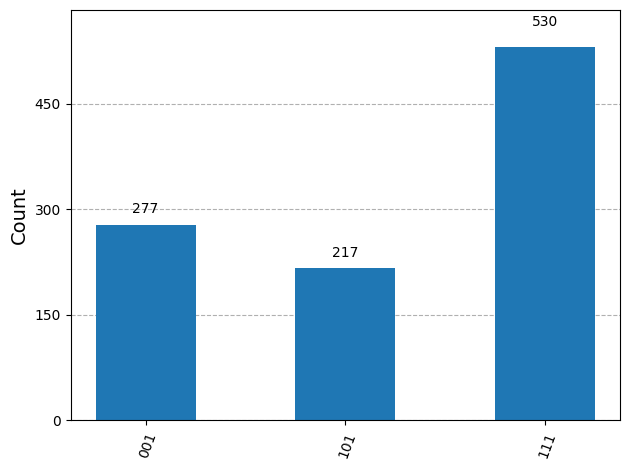

In [115]:
simulator = AerSimulator()

tcirc = transpile(qc, simulator)

result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

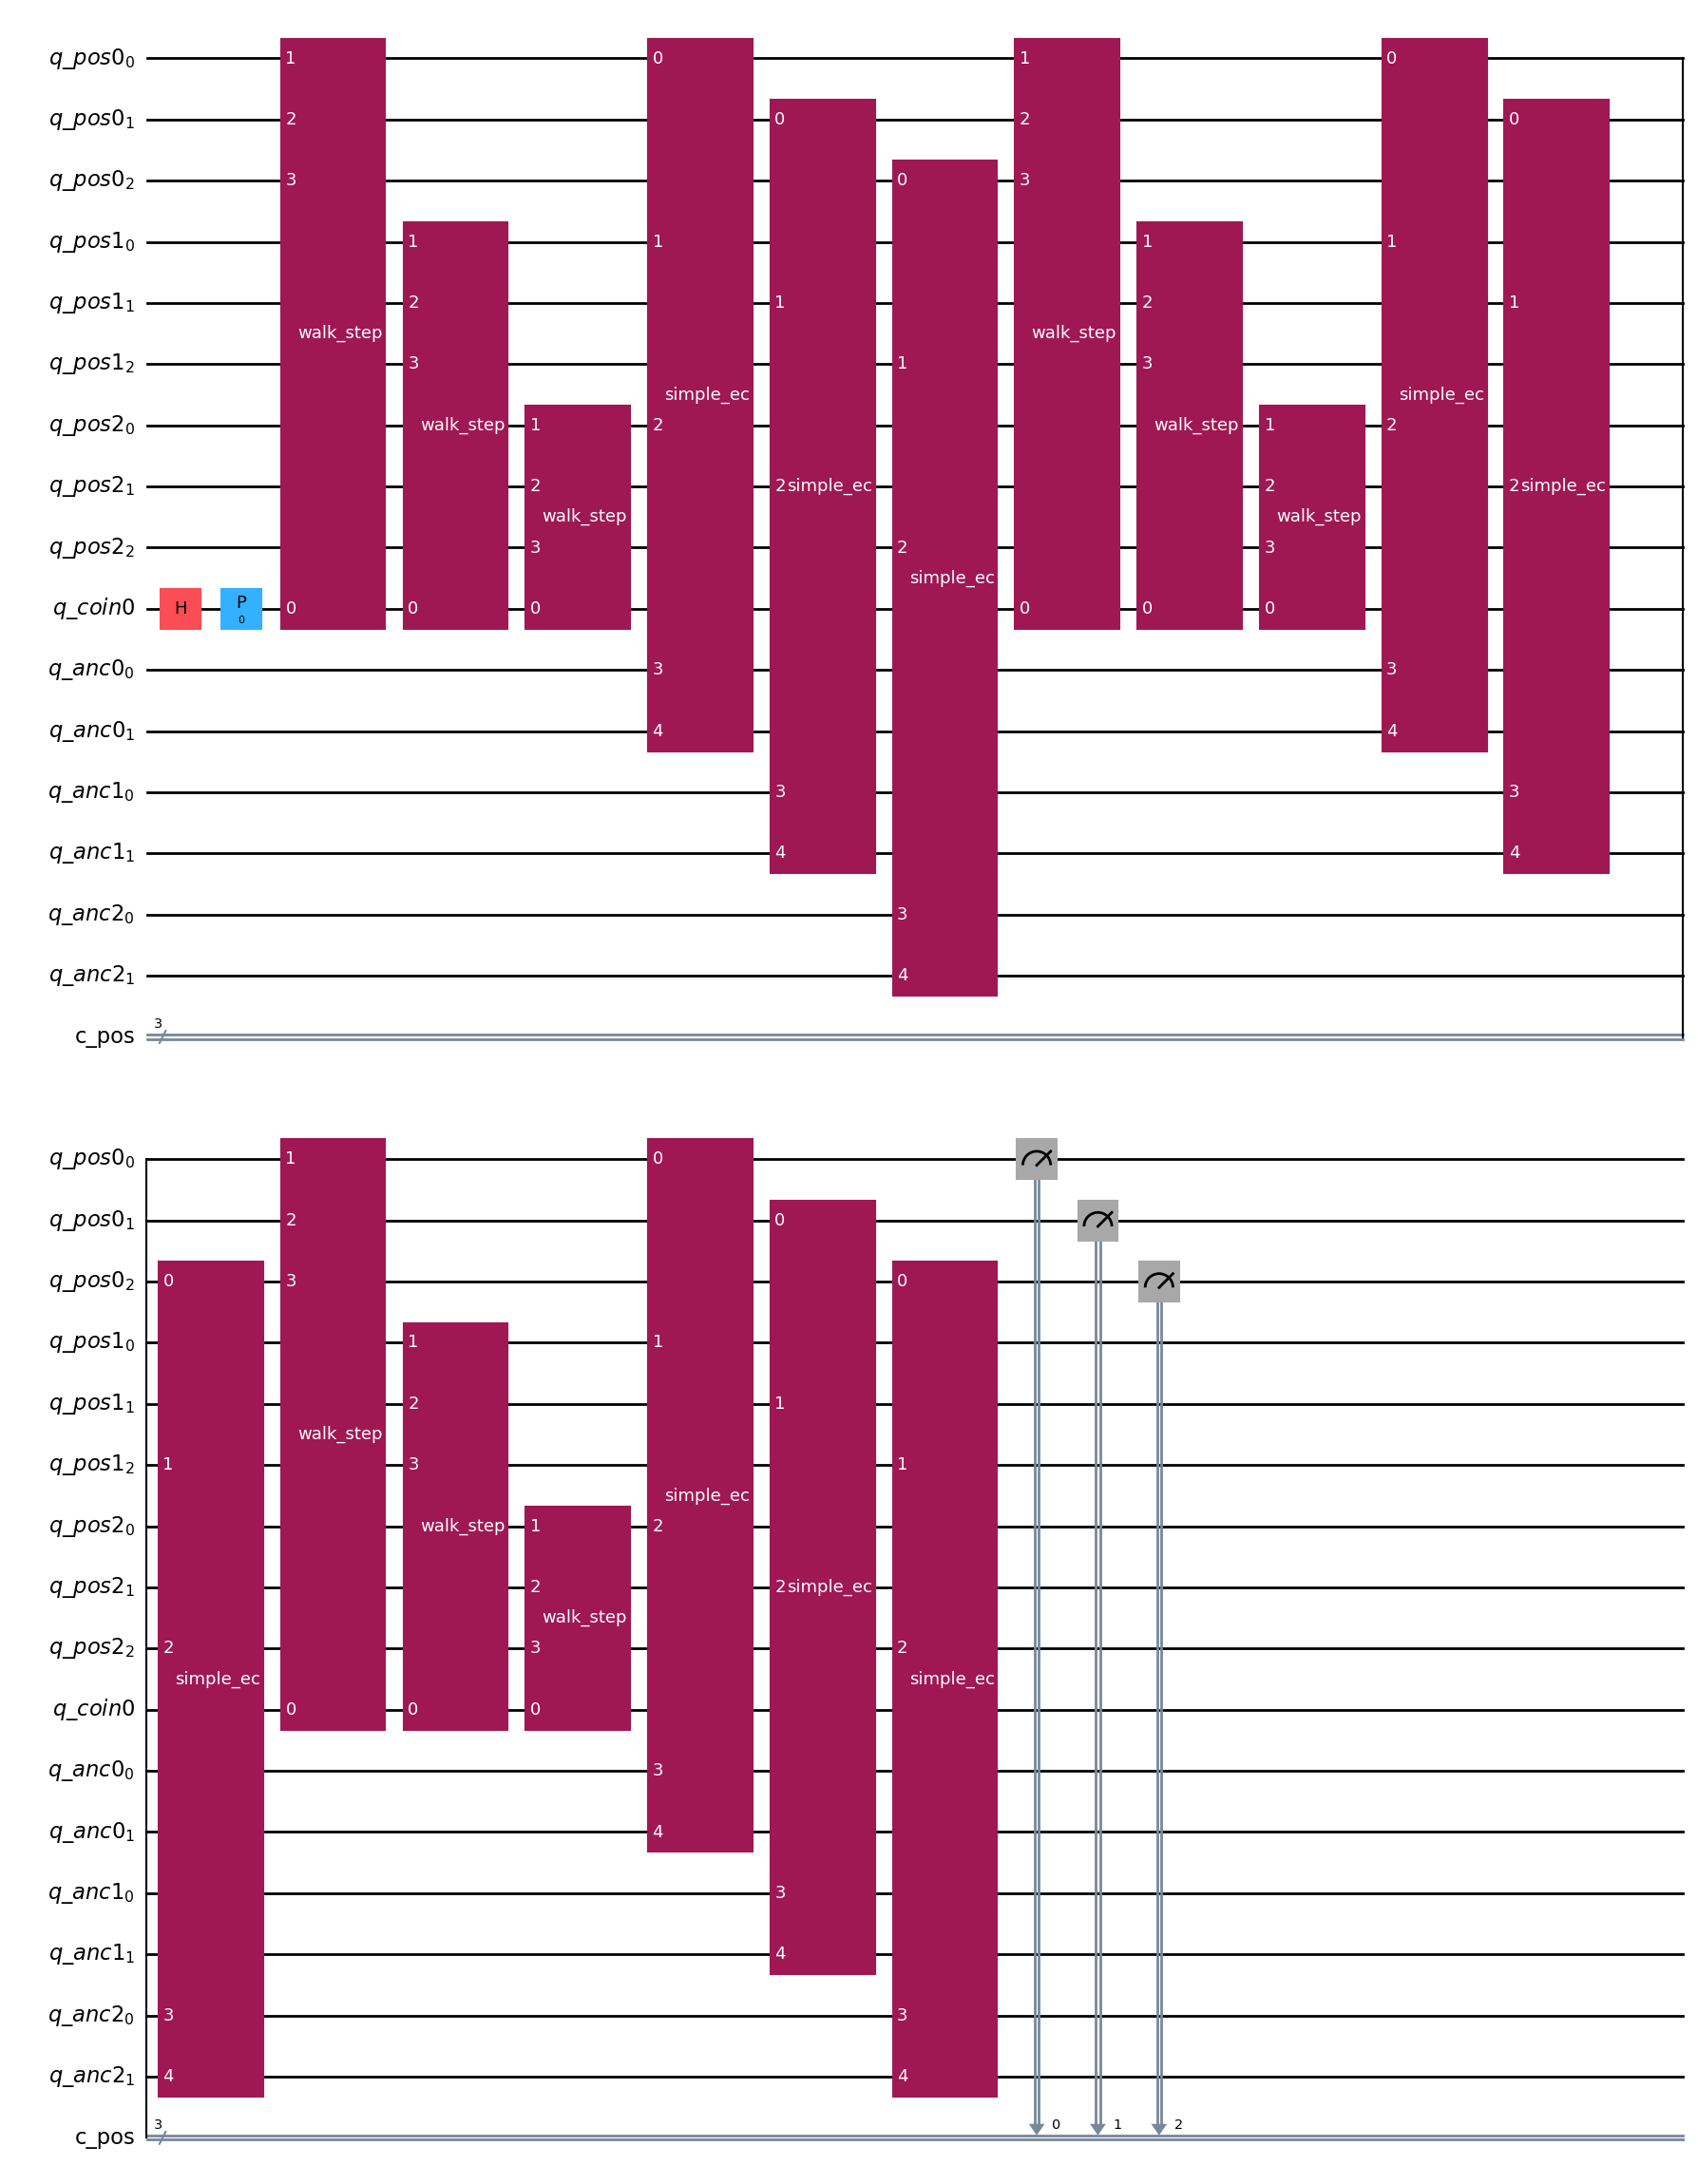

In [120]:
nodes_power = 3
num_steps = 3
coin_phase = 0

q_pos = [QuantumRegister(nodes_power, f"q_pos{i}") for i in range(nodes_power)]
q_coin = [QuantumRegister(1, f"q_coin{i}") for i in range(nodes_power)]
c_pos = ClassicalRegister(nodes_power, "c_pos")

q_anc = [QuantumRegister(2, f"q_anc{i}") for i in range(nodes_power)]

regs = []

for i in range(nodes_power):
    regs.append(q_pos[i])
    # regs.append(q_coin[i])

regs.append(q_coin[0])

for i in range(nodes_power):
    regs.append(q_anc[i])

regs.append(c_pos)

qc = QuantumCircuit(*regs)

qc.h(q_coin[0])


# qc.cx(q_coin[0], q_coin[1])
# qc.cx(q_coin[0], q_coin[2])

qc.p(coin_phase, q_coin[0])
# qc.p(coin_phase, q_coin[1])
# qc.p(coin_phase, q_coin[2])


for step in range(num_steps):
    for i in range(nodes_power):
        qc.append(walk_step(nodes_power), [q_coin[0], *q_pos[i]])
    for i in range(nodes_power):
        qc.append(simple_error_correction(), [q_pos[0][i], q_pos[1][i], q_pos[2][i], *q_anc[i]])


qc.measure(q_pos[0], c_pos)

qc.draw('mpl')

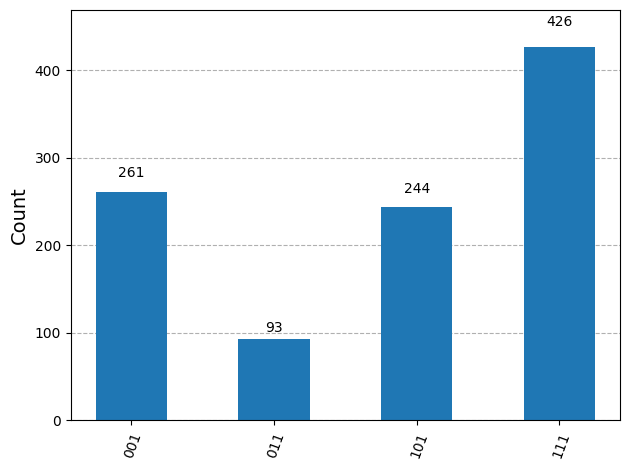

In [121]:
simulator = AerSimulator()

tcirc = transpile(qc, simulator, optimization_level=3)

result = simulator.run(tcirc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)